In [2]:
import os
import cv2
import numpy as np
from pathlib import Path
import h5py
import matplotlib.pyplot as plt
from tensorflow.keras.layers import InputLayer, Reshape, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from sklearn.metrics import  confusion_matrix,precision_score,accuracy_score,recall_score,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Nadam
import pandas as pd
import face_recognition


In [3]:
URL="./Videos"


In [4]:
metricas={"precision":[],"recall":[]}

## Funciones definidas

In [12]:
def obtenerDatos(archivo):
   data=h5py.File(archivo)
   return data["X"][:],data["Y"][:] 

In [13]:
def obtener_etiquetas(url):
    labels=[]
    for index,carpeta in enumerate(os.listdir(str(url))):
        labels.append(carpeta)
    return labels

In [14]:
def normalizar(X):
    return (X- X.min()) / (X.max() - X.min())

In [15]:
def redimensionarData(X,ancho,largo):
    imagenes=[]
    for imagen in X:
        imagenes.append(cv2.resize(imagen, (ancho, largo), interpolation=cv2.INTER_AREA))
    return np.array(imagenes)


In [16]:
def redimensionarDataYVolverRGB(X,ancho,largo):
    imagenes=[]
    for imagen in X:
        imagenes.append(cv2.cvtColor(cv2.resize(imagen, (ancho, largo), interpolation=cv2.INTER_AREA),cv2.COLOR_BGR2RGB))
    return np.array(imagenes)

In [17]:
def graficarHistorialEntrenamiento(historial):
    plt.plot(historial.history["loss"],label="costo")
    plt.plot(historial.history["val_loss"],label="costo_data_val")
    plt.plot(historial.history["accuracy"],label="precision")
    plt.plot(historial.history["val_accuracy"],label="precision_data_val")
    plt.xlabel("Epoca")
    plt.legend()
    plt.title('Evolución de la pérdida en el entrenamiento')
    plt.show()

In [18]:
def graficarMatrizDeConfusion(y_test,y_pred,labels):
    modeloCM=confusion_matrix(y_test,y_pred)
    cm=ConfusionMatrixDisplay(modeloCM,display_labels=labels)
    cm.plot()

In [19]:
def get_metricasModelo(df,y_test,y_pred):
    precision=precision_score(y_test,y_pred,average="macro")
    recall=recall_score(y_test,y_pred,average="macro")
    df["precision"].append(precision)
    df["recall"].append(recall)
    return df


In [20]:
def calculate_face_recognize(image, model="hog"):
    """
    Calcula el encoding de un rostro en una imagen.
    
    Args:
    - image: La imagen de entrada (matriz numpy).
    - model: Modelo a usar para detección de rostros ("hog" o "cnn").
    
    Returns:
    - Un vector de 128 dimensiones (encoding del rostro) si se detecta un rostro.
    - Un vector de ceros si no se detecta ningún rostro.
    """
    # Detectar ubicaciones de rostros
    face_locations = face_recognition.face_locations(image, model=model)
    
    # Calcular encodings
    encodings = face_recognition.face_encodings(image, face_locations)
    
    # Si no se detectan rostros, retorna un vector de ceros
    if len(encodings) == 0:
        return np.zeros(128)
    
    # Retorna el encoding del primer rostro detectado
    return encodings[0]

"""
HOG:

Convierte la imagen a escala de grises internamente.
Calcula características basadas en gradientes y patrones, independientemente de la escala o el brillo de la imagen.
CNN:

Trabaja directamente con imágenes RGB.
A través de sus capas convolucionales, extrae características y realiza ajustes de escala automáticamente.
"""


'\nHOG:\n\nConvierte la imagen a escala de grises internamente.\nCalcula características basadas en gradientes y patrones, independientemente de la escala o el brillo de la imagen.\nCNN:\n\nTrabaja directamente con imágenes RGB.\nA través de sus capas convolucionales, extrae características y realiza ajustes de escala automáticamente.\n'

In [21]:
def plot_image(image):
    plt.imshow(image, cmap = "gray", interpolation = "nearest")
    plt.axis("off")

## Cargamos los datos

In [22]:
X_train,y_train=obtenerDatos("./data/datos_train_color.h5")


In [23]:
X_test,y_test=obtenerDatos("./data/datos_test_color.h5")


In [24]:
X_train.shape

(2400, 200, 200, 3)

In [25]:
y_train.shape

(2400,)

In [26]:
X_test.shape

(800, 200, 200, 3)

In [27]:
y_test.shape

(800,)

## Visualizamos la data

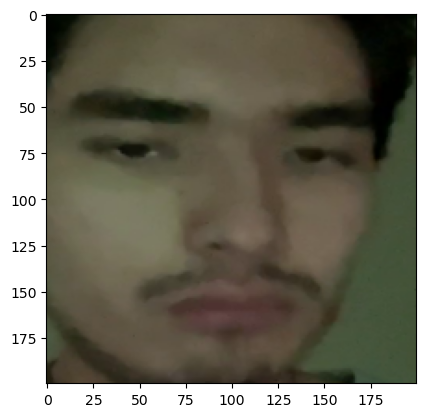

In [29]:
plt.imshow(X_train[2000])

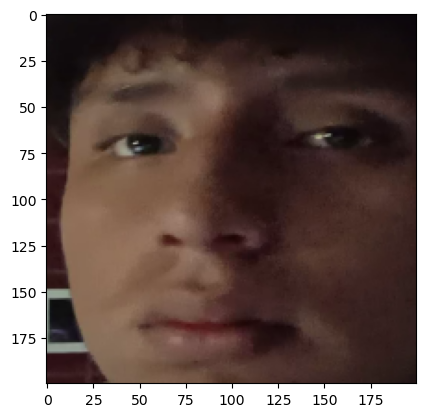

In [31]:
plt.imshow(X_train[500])

In [32]:
labels=[]

In [33]:
labels=obtener_etiquetas(URL)
labels

['Agus', 'Ale', 'Noni', 'Sebas']

In [34]:
X_train_copia=X_train.copy()
X_test_copia=X_test.copy()


In [35]:
y_train_copia=y_train.copy()
y_test_copia=y_test.copy()

In [37]:
X_train_copia=redimensionarData(X_train_copia,160,160)
X_test_copia=redimensionarData(X_test_copia,160,160)

X_train_copia = np.array([
    calculate_face_recognize(img,model="cnn")
    for img in X_train_copia
])

X_test_copia = np.array([
    calculate_face_recognize(img,model="cnn")
    for img in X_test_copia
])

X_train_copia=normalizar(X_train_copia)
X_test_copia=normalizar(X_test_copia)

In [38]:
X_train_copia.shape

(2400, 128)

In [39]:
X_test_copia.shape

(800, 128)

In [40]:
class ModeloPersonalizado:
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.modelo = None
        self.historial = None
        self.predicciones = None
        self.matriz_confusion = None

    def construir_modelo(self, configuracion):
        self.modelo = Sequential()
        self.modelo.add(InputLayer(input_shape=(self.input_dim,)))

        for capa in configuracion["capas_ocultas"]:
            self.modelo.add(Dense(capa["neuronas"], activation=capa["activation"]))
            if "dropout" in capa and capa["dropout"] > 0:
                self.modelo.add(Dropout(capa["dropout"]))

        self.modelo.add(Dense(self.output_dim, activation="softmax"))

    def compilar_modelo(self, learning_rate):
        optimizer = Nadam(learning_rate=learning_rate)
        self.modelo.compile(
            optimizer=optimizer,
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

    def entrenar_modelo(self, X_train, y_train, X_val, y_val, epochs, factor_reduccion, paciencia):
        """
        Un callback en Keras es un conjunto de funciones que puedes usar para personalizar y controlar el proceso de entrenamiento del modelo
        ReduceLROnPlateau es un callback en Keras que se utiliza para reducir la tasa de aprendizaje (learning rate)
        automáticamente si una métrica(val_loss) no mejora después de un número definido de épocas (patience).
        min_lr:El learning rate no se reducirá por debajo de este valor, lo que previene que se acerque a cero.
        lr_scheduler=planificador de la tasa de aprendizaje

        Todo este trabajo se hace poruqe la tasa de aprendizaje se encarga de enontrar el j mas pequeno para los thetas
        si este j o en nuestro caso el val_loss ya no baja mucho o de la nada se subio su valor que posiblemente estemos cerca al mejor
        j o val_loss posible para los tethas y nos conviende dar pasitos mas cortos en la tasa de aprendizaje cuidando de que no sea cero con 
        min_lr
        """
        lr_scheduler = ReduceLROnPlateau(
            monitor="val_loss",
            factor=factor_reduccion,
            patience=paciencia,
            verbose=1,
            min_lr=1e-6
        )

        self.historial = self.modelo.fit(
            X_train, 
            y_train, 
            epochs=epochs, 
            validation_data=(X_val, y_val), 
            callbacks=[lr_scheduler], 
            verbose=1
        )

    def evaluar_modelo(self, X_test, y_test, labels, configuracion):
        probabilidades = self.modelo.predict(X_test)
        self.predicciones = np.argmax(probabilidades, axis=1)

        #El macro average calcula la precisión y el recall de forma independiente para cada clase. Luego toma el promedio aritmético de esas métricas.
        precision = precision_score(y_test, self.predicciones, average="macro")
        recall = recall_score(y_test, self.predicciones, average="macro")

        self.matriz_confusion = confusion_matrix(y_test, self.predicciones)

        resultados = {
            "configuracion": configuracion,
            "precision": precision,
            "recall": recall,
            "historial": self.historial.history,
            "matriz_confusion": self.matriz_confusion
        }

        return resultados

In [41]:
configuraciones = [
    # Etapa 1: 
    {
        "capas_ocultas": [{"neuronas": 32, "activation": "relu", "dropout": 0.1}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [{"neuronas": 32, "activation": "tanh", "dropout": 0.1}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [{"neuronas": 32, "activation": "leaky_relu", "dropout": 0.1}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [{"neuronas": 32, "activation": "swish", "dropout": 0.1}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [{"neuronas": 64, "activation": "relu", "dropout": 0.1}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [{"neuronas": 64, "activation": "tanh", "dropout": 0.1}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [{"neuronas": 64, "activation": "leaky_relu", "dropout": 0.1}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [{"neuronas": 64, "activation": "swish", "dropout": 0.1}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [{"neuronas": 128, "activation": "relu", "dropout": 0.2}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [{"neuronas": 128, "activation": "tanh", "dropout": 0.2}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [{"neuronas": 128, "activation": "leaky_relu", "dropout": 0.2}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [{"neuronas": 128, "activation": "swish", "dropout": 0.2}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    
    # Etapa 2: 
    {
        "capas_ocultas": [
            {"neuronas": 128, "activation": "relu", "dropout": 0.2},
            {"neuronas": 64, "activation": "relu", "dropout": 0.2},
        ],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [
            {"neuronas": 128, "activation": "leaky_relu", "dropout": 0.2},
            {"neuronas": 64, "activation": "leaky_relu", "dropout": 0.2},
        ],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [
            {"neuronas": 128, "activation": "swish", "dropout": 0.2},
            {"neuronas": 64, "activation": "swish", "dropout": 0.2},
        ],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [
            {"neuronas": 64, "activation": "relu", "dropout": 0.2},
            {"neuronas": 32, "activation": "relu", "dropout": 0.2},
        ],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [
            {"neuronas": 64, "activation": "leaky_relu", "dropout": 0.2},
            {"neuronas": 32, "activation": "leaky_relu", "dropout": 0.2},
        ],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [
            {"neuronas": 64, "activation": "swish", "dropout": 0.2},
            {"neuronas": 32, "activation": "swish", "dropout": 0.2},
        ],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },

    # Etapa 3: 
    {
        "capas_ocultas": [
            {"neuronas": 128, "activation": "relu", "dropout": 0.2},
            {"neuronas": 64, "activation": "relu", "dropout": 0.15},
            {"neuronas": 32, "activation": "relu", "dropout": 0.1},
        ],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [
            {"neuronas": 128, "activation": "leaky_relu", "dropout": 0.2},
            {"neuronas": 64, "activation": "leaky_relu", "dropout": 0.15},
            {"neuronas": 32, "activation": "leaky_relu", "dropout": 0.1},
        ],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [
            {"neuronas": 128, "activation": "swish", "dropout": 0.2},
            {"neuronas": 64, "activation": "swish", "dropout": 0.15},
            {"neuronas": 32, "activation": "swish", "dropout": 0.1},
        ],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [
            {"neuronas": 64, "activation": "relu", "dropout": 0.15},
            {"neuronas": 32, "activation": "relu", "dropout": 0.1},
            {"neuronas": 16, "activation": "relu", "dropout": 0.05},
        ],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [
            {"neuronas": 64, "activation": "leaky_relu", "dropout": 0.15},
            {"neuronas": 32, "activation": "leaky_relu", "dropout": 0.1},
            {"neuronas": 16, "activation": "leaky_relu", "dropout": 0.05},
        ],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    },
    {
        "capas_ocultas": [
            {"neuronas": 64, "activation": "swish", "dropout": 0.15},
            {"neuronas": 32, "activation": "swish", "dropout": 0.1},
            {"neuronas": 16, "activation": "swish", "dropout": 0.05},
        ],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"},
    }
]

resultados_metricas = []

for idx, config in enumerate(configuraciones):
    print(f"Entrenando modelo {idx + 1}/{len(configuraciones)}...")

    modelo = ModeloPersonalizado(input_dim=128, output_dim=4)
    modelo.construir_modelo(config)
    modelo.compilar_modelo(learning_rate=config["learning_rate"])
    modelo.entrenar_modelo(
        X_train=X_train_copia,
        y_train=y_train,
        X_val=X_test_copia,
        y_val=y_test,
        epochs=50,
        factor_reduccion=config["factor_reduccion"],
        paciencia=5,
    )
    
    resultados = modelo.evaluar_modelo(
        X_test=X_test_copia,
        y_test=y_test,
        labels=labels,
        configuracion=config
    )
    resultados_metricas.append(resultados)

    print(f"Modelo {idx + 1} se acabo de entrenar y se guardo")

df_resultados = pd.DataFrame(resultados_metricas)


Entrenando modelo 1/24...
Epoch 1/50


C:\Users\MSI DESKTOP\anaconda3\envs\dlib_env\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3051 - loss: 1.3775 - val_accuracy: 0.6587 - val_loss: 1.2568 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5891 - loss: 1.2540 - val_accuracy: 0.8438 - val_loss: 1.1360 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7954 - loss: 1.1333 - val_accuracy: 0.9987 - val_loss: 0.9787 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9104 - loss: 0.9612 - val_accuracy: 1.0000 - val_loss: 0.8000 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9544 - loss: 0.7852 - val_accuracy: 1.0000 - val_loss: 0.6353 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9685 - loss: 0.6307 - val_accuracy: 0.9987 - val_loss: 0.5083 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9827 - loss: 0.4913 - val_accuracy: 1.0000 - va

C:\Users\MSI DESKTOP\anaconda3\envs\dlib_env\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3157 - loss: 1.3944 - val_accuracy: 0.9688 - val_loss: 1.1942 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7142 - loss: 1.1495 - val_accuracy: 0.9912 - val_loss: 0.9455 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9856 - loss: 0.8735 - val_accuracy: 1.0000 - val_loss: 0.6891 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9884 - loss: 0.6185 - val_accuracy: 1.0000 - val_loss: 0.4602 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.4165 - val_accuracy: 1.0000 - val_loss: 0.3124 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.2771 - val_accuracy: 1.0000 - val_loss: 0.2211 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.1880 - val_accuracy: 1.0000 - va

C:\Users\MSI DESKTOP\anaconda3\envs\dlib_env\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4069 - loss: 1.3474 - val_accuracy: 0.9000 - val_loss: 1.2273 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8050 - loss: 1.1708 - val_accuracy: 0.9675 - val_loss: 0.9825 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9257 - loss: 0.9179 - val_accuracy: 1.0000 - val_loss: 0.7271 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9749 - loss: 0.6831 - val_accuracy: 1.0000 - val_loss: 0.5212 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9848 - loss: 0.4788 - val_accuracy: 1.0000 - val_loss: 0.3666 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9864 - loss: 0.3426 - val_accuracy: 1.0000 - val_loss: 0.2750 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.2498 - val_accuracy: 1.0000 - va

C:\Users\MSI DESKTOP\anaconda3\envs\dlib_env\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3338 - loss: 1.3648 - val_accuracy: 0.7287 - val_loss: 1.2330 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6839 - loss: 1.1896 - val_accuracy: 0.8913 - val_loss: 0.9903 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8161 - loss: 0.9481 - val_accuracy: 0.9075 - val_loss: 0.7582 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8538 - loss: 0.7444 - val_accuracy: 0.9987 - val_loss: 0.5359 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9199 - loss: 0.5626 - val_accuracy: 0.9975 - val_loss: 0.4058 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9408 - loss: 0.4358 - val_accuracy: 1.0000 - val_loss: 0.3008 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9549 - loss: 0.3470 - val_accuracy: 1.0000 - va

C:\Users\MSI DESKTOP\anaconda3\envs\dlib_env\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3543 - loss: 1.3640 - val_accuracy: 0.7837 - val_loss: 1.2469 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6973 - loss: 1.2160 - val_accuracy: 0.9987 - val_loss: 1.0808 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8790 - loss: 1.0426 - val_accuracy: 1.0000 - val_loss: 0.8703 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9768 - loss: 0.8178 - val_accuracy: 0.9925 - val_loss: 0.6541 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9841 - loss: 0.6045 - val_accuracy: 1.0000 - val_loss: 0.4616 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9936 - loss: 0.4289 - val_accuracy: 1.0000 - val_loss: 0.3275 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.3117 - val_accuracy: 1.0000 - va

C:\Users\MSI DESKTOP\anaconda3\envs\dlib_env\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2853 - loss: 1.4155 - val_accuracy: 0.5825 - val_loss: 1.2097 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6692 - loss: 1.1333 - val_accuracy: 1.0000 - val_loss: 0.8922 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9808 - loss: 0.7963 - val_accuracy: 1.0000 - val_loss: 0.5745 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.4901 - val_accuracy: 1.0000 - val_loss: 0.3354 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.2802 - val_accuracy: 1.0000 - val_loss: 0.2194 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.1731 - val_accuracy: 1.0000 - val_loss: 0.1479 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.1177 - val_accuracy: 1.0000 - va

C:\Users\MSI DESKTOP\anaconda3\envs\dlib_env\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3560 - loss: 1.3581 - val_accuracy: 0.9237 - val_loss: 1.1897 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7779 - loss: 1.1286 - val_accuracy: 0.9325 - val_loss: 0.9154 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9454 - loss: 0.8293 - val_accuracy: 0.9900 - val_loss: 0.5999 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9841 - loss: 0.5363 - val_accuracy: 1.0000 - val_loss: 0.3684 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.3225 - val_accuracy: 1.0000 - val_loss: 0.2462 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9933 - loss: 0.2047 - val_accuracy: 1.0000 - val_loss: 0.1363 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.1213 - val_accuracy: 1.0000 - va

C:\Users\MSI DESKTOP\anaconda3\envs\dlib_env\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3706 - loss: 1.3479 - val_accuracy: 0.8950 - val_loss: 1.1961 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7403 - loss: 1.1108 - val_accuracy: 0.9812 - val_loss: 0.8293 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8883 - loss: 0.7678 - val_accuracy: 1.0000 - val_loss: 0.5090 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9440 - loss: 0.5053 - val_accuracy: 0.9875 - val_loss: 0.3327 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9600 - loss: 0.3474 - val_accuracy: 1.0000 - val_loss: 0.2273 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9822 - loss: 0.2365 - val_accuracy: 1.0000 - val_loss: 0.1673 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9827 - loss: 0.1812 - val_accuracy: 1.0000 - va

C:\Users\MSI DESKTOP\anaconda3\envs\dlib_env\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2949 - loss: 1.3864 - val_accuracy: 0.7250 - val_loss: 1.2079 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7399 - loss: 1.1464 - val_accuracy: 0.9737 - val_loss: 0.9478 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9462 - loss: 0.8720 - val_accuracy: 1.0000 - val_loss: 0.6406 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9724 - loss: 0.5803 - val_accuracy: 1.0000 - val_loss: 0.4214 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9902 - loss: 0.3712 - val_accuracy: 1.0000 - val_loss: 0.2633 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9935 - loss: 0.2553 - val_accuracy: 1.0000 - val_loss: 0.1861 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.1697 - val_accuracy: 1.0000 - va

C:\Users\MSI DESKTOP\anaconda3\envs\dlib_env\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3779 - loss: 1.3352 - val_accuracy: 1.0000 - val_loss: 1.0132 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9039 - loss: 0.9002 - val_accuracy: 1.0000 - val_loss: 0.6074 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9922 - loss: 0.5017 - val_accuracy: 1.0000 - val_loss: 0.3212 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.2645 - val_accuracy: 1.0000 - val_loss: 0.1847 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9935 - loss: 0.1538 - val_accuracy: 1.0000 - val_loss: 0.1266 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9952 - loss: 0.0972 - val_accuracy: 1.0000 - val_loss: 0.0835 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9953 - loss: 0.0692 - val_accuracy: 1.0000 - va

C:\Users\MSI DESKTOP\anaconda3\envs\dlib_env\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3762 - loss: 1.3344 - val_accuracy: 0.8888 - val_loss: 1.1103 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8464 - loss: 0.9955 - val_accuracy: 0.9837 - val_loss: 0.6989 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9897 - loss: 0.5700 - val_accuracy: 0.9987 - val_loss: 0.3622 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9927 - loss: 0.2941 - val_accuracy: 1.0000 - val_loss: 0.1912 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9935 - loss: 0.1628 - val_accuracy: 1.0000 - val_loss: 0.1245 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9967 - loss: 0.0992 - val_accuracy: 1.0000 - val_loss: 0.0927 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9950 - loss: 0.0733 - val_accuracy: 1.0000 - va

C:\Users\MSI DESKTOP\anaconda3\envs\dlib_env\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3418 - loss: 1.3530 - val_accuracy: 0.7387 - val_loss: 1.1297 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7235 - loss: 1.0385 - val_accuracy: 0.9762 - val_loss: 0.7104 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9110 - loss: 0.6568 - val_accuracy: 1.0000 - val_loss: 0.3753 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9487 - loss: 0.3963 - val_accuracy: 1.0000 - val_loss: 0.2397 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9726 - loss: 0.2558 - val_accuracy: 1.0000 - val_loss: 0.1681 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9867 - loss: 0.1712 - val_accuracy: 1.0000 - val_loss: 0.1132 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9849 - loss: 0.1339 - val_accuracy: 1.0000 - va

C:\Users\MSI DESKTOP\anaconda3\envs\dlib_env\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3421 - loss: 1.3563 - val_accuracy: 0.6237 - val_loss: 1.1491 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7370 - loss: 1.0361 - val_accuracy: 0.9987 - val_loss: 0.5116 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9601 - loss: 0.4356 - val_accuracy: 1.0000 - val_loss: 0.1538 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9858 - loss: 0.1540 - val_accuracy: 1.0000 - val_loss: 0.0657 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9908 - loss: 0.0788 - val_accuracy: 1.0000 - val_loss: 0.0360 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9934 - loss: 0.0492 - val_accuracy: 1.0000 - val_loss: 0.0316 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0413 - val_accuracy: 1.0000 - va

C:\Users\MSI DESKTOP\anaconda3\envs\dlib_env\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3531 - loss: 1.3500 - val_accuracy: 0.9600 - val_loss: 1.0096 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8751 - loss: 0.8390 - val_accuracy: 1.0000 - val_loss: 0.2603 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9820 - loss: 0.2196 - val_accuracy: 0.9975 - val_loss: 0.0778 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9929 - loss: 0.0715 - val_accuracy: 1.0000 - val_loss: 0.0353 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0399 - val_accuracy: 1.0000 - val_loss: 0.0236 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0344 - val_accuracy: 0.9900 - val_loss: 0.0384 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0328 - val_accuracy: 1.0000 - va

C:\Users\MSI DESKTOP\anaconda3\envs\dlib_env\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3436 - loss: 1.3543 - val_accuracy: 0.9712 - val_loss: 0.9760 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7421 - loss: 0.8673 - val_accuracy: 0.9950 - val_loss: 0.2657 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9292 - loss: 0.3100 - val_accuracy: 1.0000 - val_loss: 0.0921 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9732 - loss: 0.1554 - val_accuracy: 1.0000 - val_loss: 0.0540 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9826 - loss: 0.0899 - val_accuracy: 1.0000 - val_loss: 0.0305 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9924 - loss: 0.0600 - val_accuracy: 1.0000 - val_loss: 0.0346 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9923 - loss: 0.0473 - val_accuracy: 1.0000 - va

C:\Users\MSI DESKTOP\anaconda3\envs\dlib_env\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3002 - loss: 1.3732 - val_accuracy: 0.5487 - val_loss: 1.2344 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6169 - loss: 1.1739 - val_accuracy: 0.9875 - val_loss: 0.8615 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8556 - loss: 0.7783 - val_accuracy: 0.9787 - val_loss: 0.4545 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9185 - loss: 0.4402 - val_accuracy: 1.0000 - val_loss: 0.2184 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9642 - loss: 0.2489 - val_accuracy: 1.0000 - val_loss: 0.1143 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9757 - loss: 0.1560 - val_accuracy: 1.0000 - val_loss: 0.0670 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9866 - loss: 0.1022 - val_accuracy: 1.0000 - va

C:\Users\MSI DESKTOP\anaconda3\envs\dlib_env\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3202 - loss: 1.3704 - val_accuracy: 0.8988 - val_loss: 1.1486 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6985 - loss: 1.0751 - val_accuracy: 1.0000 - val_loss: 0.6033 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9432 - loss: 0.5195 - val_accuracy: 1.0000 - val_loss: 0.2091 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9850 - loss: 0.2146 - val_accuracy: 1.0000 - val_loss: 0.1077 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9899 - loss: 0.1122 - val_accuracy: 1.0000 - val_loss: 0.0584 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9895 - loss: 0.0791 - val_accuracy: 1.0000 - val_loss: 0.0463 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0540 - val_accuracy: 1.0000 - va

C:\Users\MSI DESKTOP\anaconda3\envs\dlib_env\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3120 - loss: 1.3593 - val_accuracy: 0.6313 - val_loss: 1.2258 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5917 - loss: 1.1247 - val_accuracy: 0.9975 - val_loss: 0.7112 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8007 - loss: 0.7106 - val_accuracy: 0.9987 - val_loss: 0.3068 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9309 - loss: 0.3642 - val_accuracy: 1.0000 - val_loss: 0.1461 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9634 - loss: 0.1991 - val_accuracy: 1.0000 - val_loss: 0.0917 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9815 - loss: 0.1278 - val_accuracy: 1.0000 - val_loss: 0.0507 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9874 - loss: 0.0901 - val_accuracy: 1.0000 - va

C:\Users\MSI DESKTOP\anaconda3\envs\dlib_env\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2902 - loss: 1.3752 - val_accuracy: 0.9125 - val_loss: 1.1874 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6454 - loss: 1.0889 - val_accuracy: 0.9987 - val_loss: 0.3216 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9591 - loss: 0.3026 - val_accuracy: 1.0000 - val_loss: 0.0585 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9908 - loss: 0.0872 - val_accuracy: 1.0000 - val_loss: 0.0351 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9930 - loss: 0.0560 - val_accuracy: 1.0000 - val_loss: 0.0184 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9889 - loss: 0.0525 - val_accuracy: 0.9987 - val_loss: 0.0159 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9928 - loss: 0.0374 - val_accuracy: 1.0000 - va

C:\Users\MSI DESKTOP\anaconda3\envs\dlib_env\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3698 - loss: 1.3126 - val_accuracy: 0.9550 - val_loss: 0.7465 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8829 - loss: 0.5313 - val_accuracy: 1.0000 - val_loss: 0.0894 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9866 - loss: 0.0942 - val_accuracy: 1.0000 - val_loss: 0.0247 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9892 - loss: 0.0498 - val_accuracy: 1.0000 - val_loss: 0.0288 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9934 - loss: 0.0354 - val_accuracy: 1.0000 - val_loss: 0.0231 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9937 - loss: 0.0313 - val_accuracy: 1.0000 - val_loss: 0.0167 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0252 - val_accuracy: 1.0000 - va

C:\Users\MSI DESKTOP\anaconda3\envs\dlib_env\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2931 - loss: 1.3606 - val_accuracy: 0.9987 - val_loss: 0.9097 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7437 - loss: 0.7352 - val_accuracy: 1.0000 - val_loss: 0.1149 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9365 - loss: 0.2231 - val_accuracy: 1.0000 - val_loss: 0.0317 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9787 - loss: 0.0990 - val_accuracy: 1.0000 - val_loss: 0.0167 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9904 - loss: 0.0503 - val_accuracy: 1.0000 - val_loss: 0.0167 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9922 - loss: 0.0453 - val_accuracy: 1.0000 - val_loss: 0.0069 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9905 - loss: 0.0367 - val_accuracy: 0.9975 - va

C:\Users\MSI DESKTOP\anaconda3\envs\dlib_env\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2763 - loss: 1.3955 - val_accuracy: 0.4775 - val_loss: 1.3024 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5230 - loss: 1.2458 - val_accuracy: 1.0000 - val_loss: 0.8304 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8051 - loss: 0.8107 - val_accuracy: 0.9925 - val_loss: 0.4086 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9139 - loss: 0.4056 - val_accuracy: 1.0000 - val_loss: 0.1307 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9586 - loss: 0.1958 - val_accuracy: 1.0000 - val_loss: 0.0574 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9796 - loss: 0.1176 - val_accuracy: 0.9937 - val_loss: 0.0507 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9783 - loss: 0.0893 - val_accuracy: 1.0000 - va

C:\Users\MSI DESKTOP\anaconda3\envs\dlib_env\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2990 - loss: 1.3739 - val_accuracy: 0.7287 - val_loss: 1.2112 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6441 - loss: 1.0783 - val_accuracy: 0.9300 - val_loss: 0.4208 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9280 - loss: 0.3896 - val_accuracy: 1.0000 - val_loss: 0.1134 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9764 - loss: 0.1435 - val_accuracy: 1.0000 - val_loss: 0.0372 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9900 - loss: 0.0726 - val_accuracy: 1.0000 - val_loss: 0.0277 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9926 - loss: 0.0497 - val_accuracy: 1.0000 - val_loss: 0.0151 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9891 - loss: 0.0481 - val_accuracy: 1.0000 - va

C:\Users\MSI DESKTOP\anaconda3\envs\dlib_env\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3324 - loss: 1.3646 - val_accuracy: 0.6850 - val_loss: 1.1288 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6427 - loss: 1.0095 - val_accuracy: 1.0000 - val_loss: 0.3676 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8599 - loss: 0.4538 - val_accuracy: 0.9962 - val_loss: 0.1516 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9305 - loss: 0.2384 - val_accuracy: 0.9987 - val_loss: 0.0676 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9648 - loss: 0.1413 - val_accuracy: 1.0000 - val_loss: 0.0309 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9807 - loss: 0.0880 - val_accuracy: 1.0000 - val_loss: 0.0240 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9874 - loss: 0.0669 - val_accuracy: 0.9987 - va

Modelo 1:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 32 neuronas, activación='relu', dropout=0.1
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 1.0000
Recall: 1.0000

Graficando historial de entrenamiento...


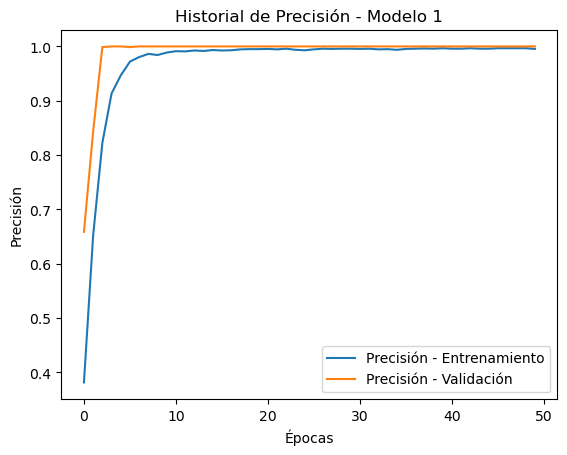

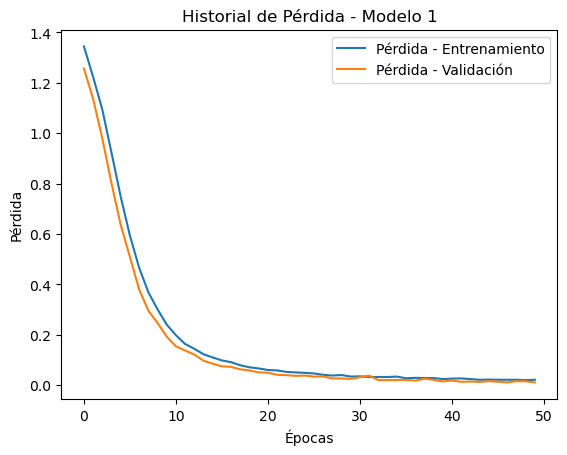


Matriz de Confusión:


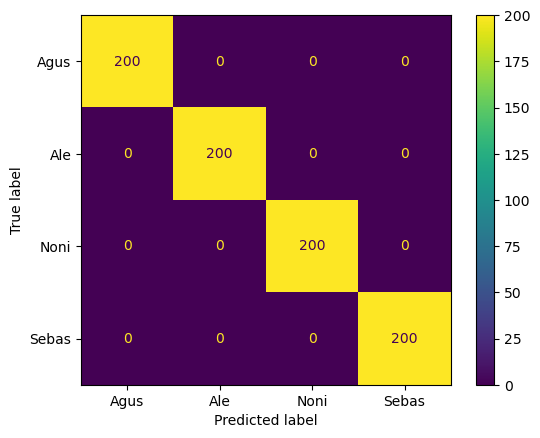



Modelo 2:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 32 neuronas, activación='tanh', dropout=0.1
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 1.0000
Recall: 1.0000

Graficando historial de entrenamiento...


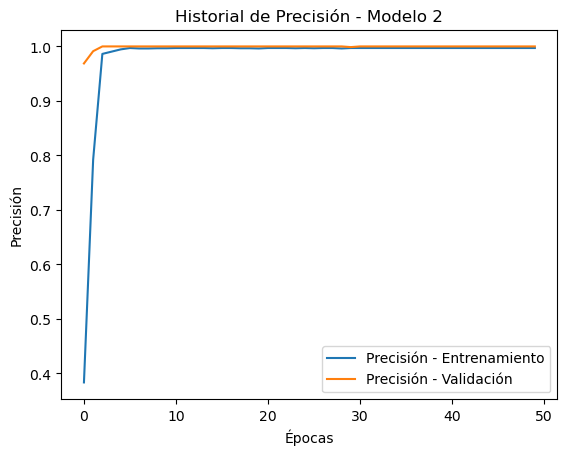

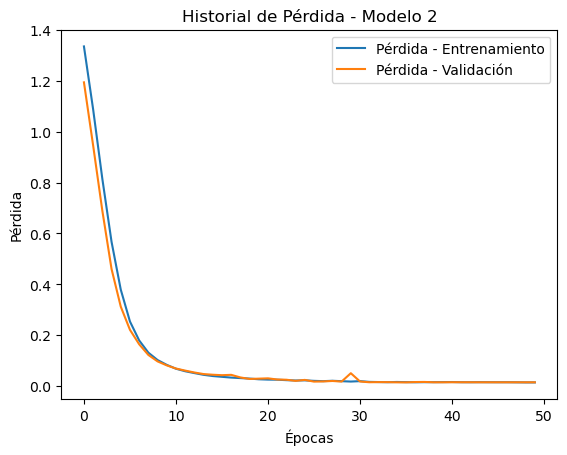


Matriz de Confusión:


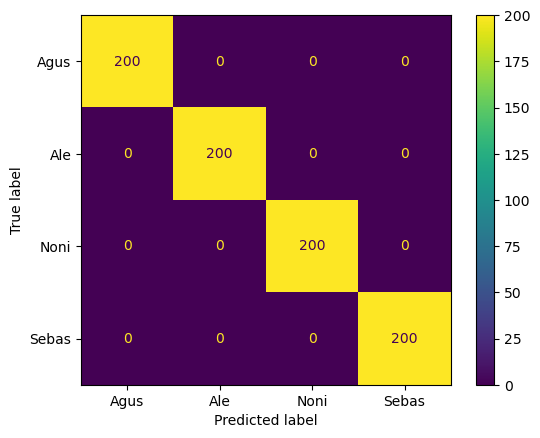



Modelo 3:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 32 neuronas, activación='leaky_relu', dropout=0.1
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 1.0000
Recall: 1.0000

Graficando historial de entrenamiento...


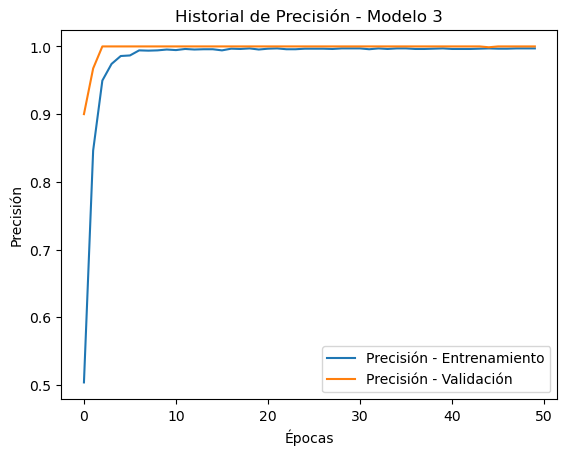

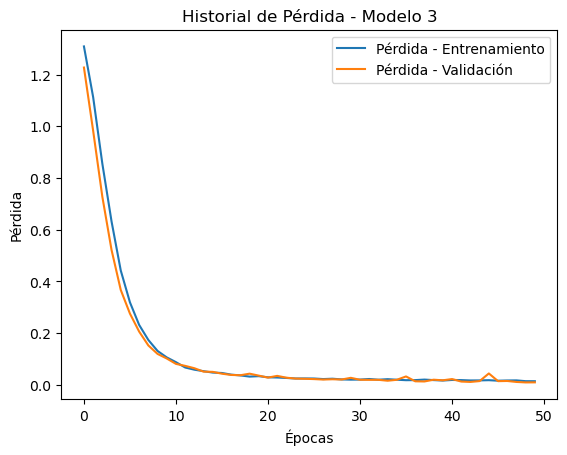


Matriz de Confusión:


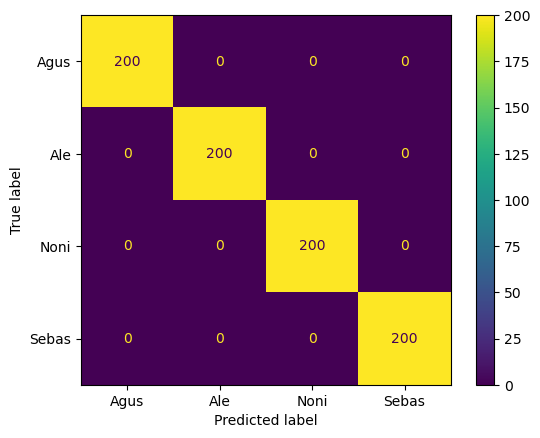



Modelo 4:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 32 neuronas, activación='swish', dropout=0.1
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 1.0000
Recall: 1.0000

Graficando historial de entrenamiento...


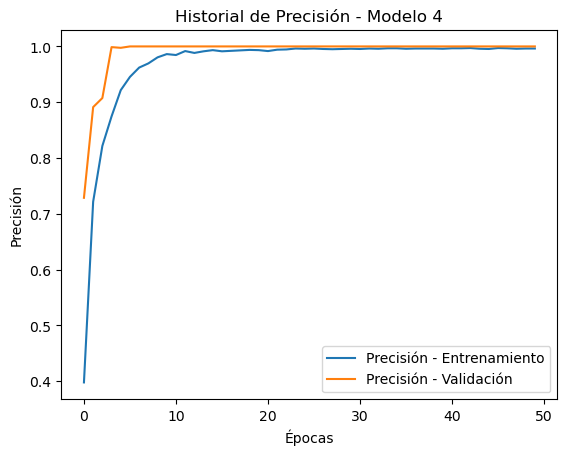

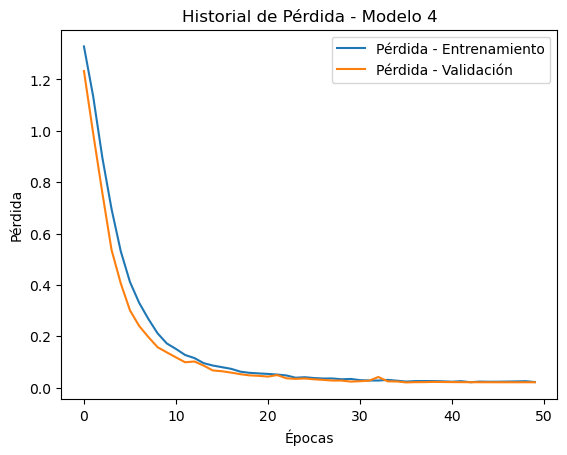


Matriz de Confusión:


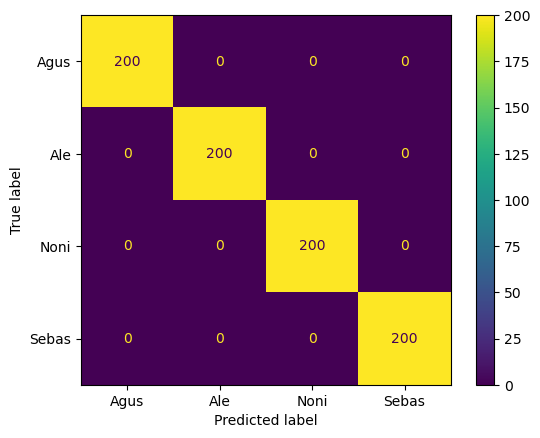



Modelo 5:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 64 neuronas, activación='relu', dropout=0.1
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 1.0000
Recall: 1.0000

Graficando historial de entrenamiento...


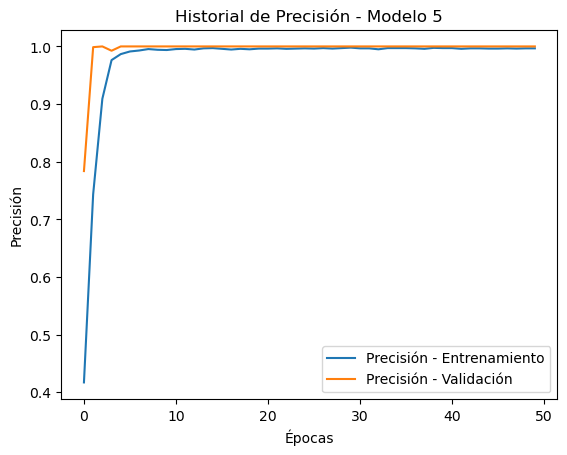

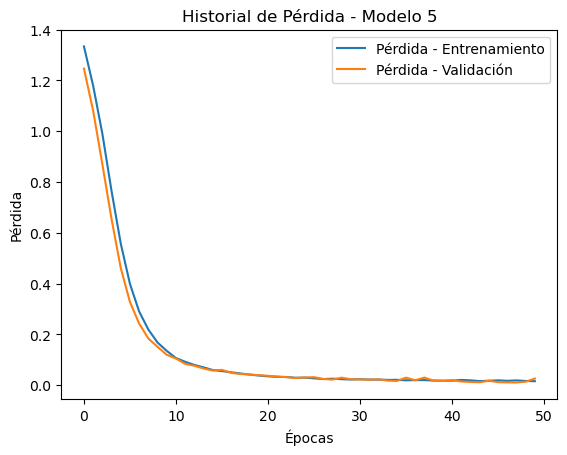


Matriz de Confusión:


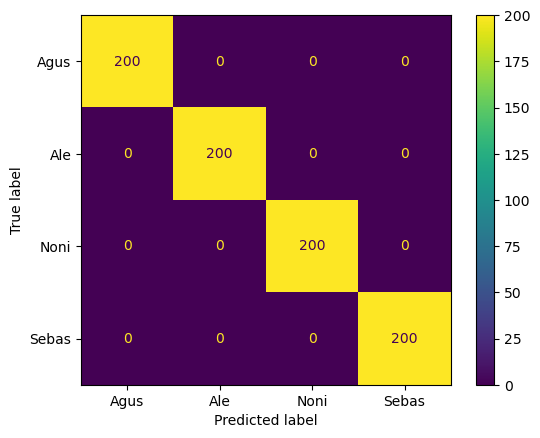



Modelo 6:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 64 neuronas, activación='tanh', dropout=0.1
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 1.0000
Recall: 1.0000

Graficando historial de entrenamiento...


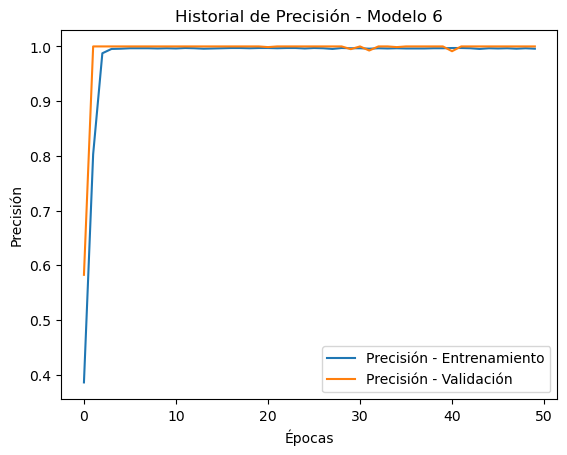

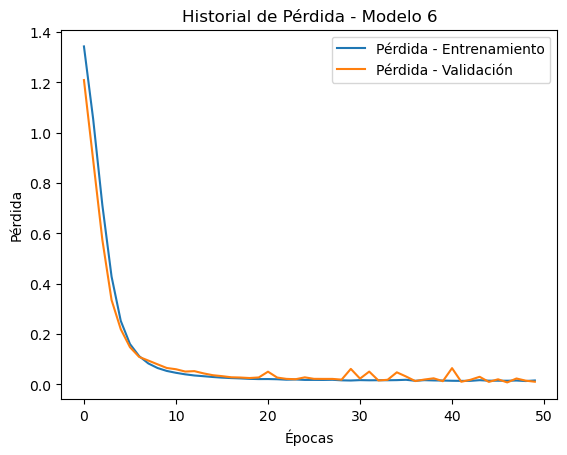


Matriz de Confusión:


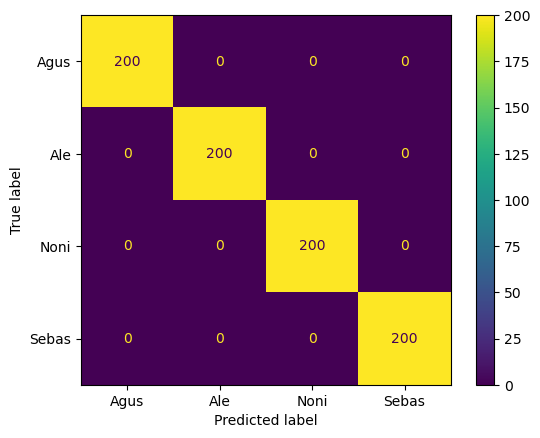



Modelo 7:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 64 neuronas, activación='leaky_relu', dropout=0.1
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 1.0000
Recall: 1.0000

Graficando historial de entrenamiento...


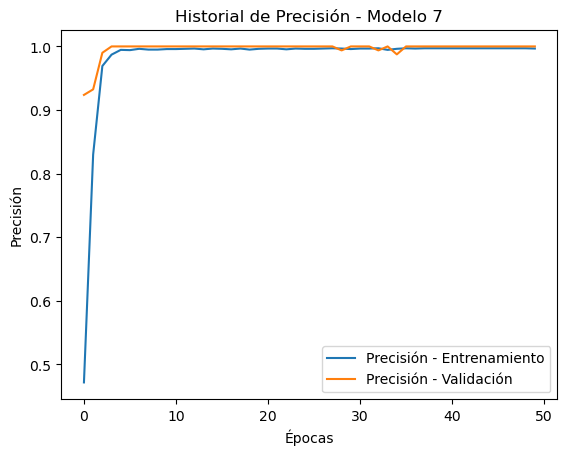

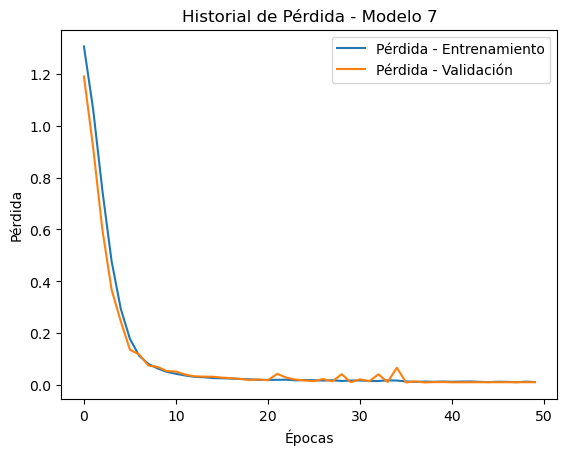


Matriz de Confusión:


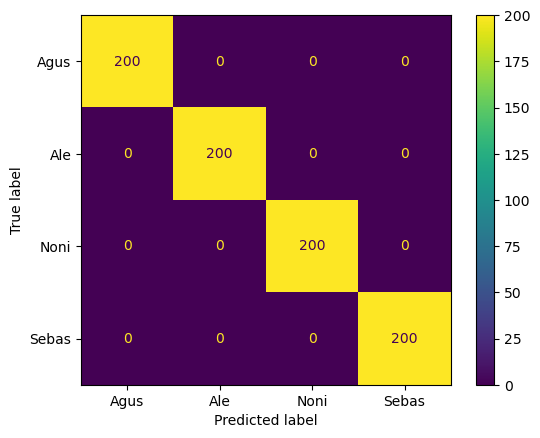



Modelo 8:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 64 neuronas, activación='swish', dropout=0.1
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 1.0000
Recall: 1.0000

Graficando historial de entrenamiento...


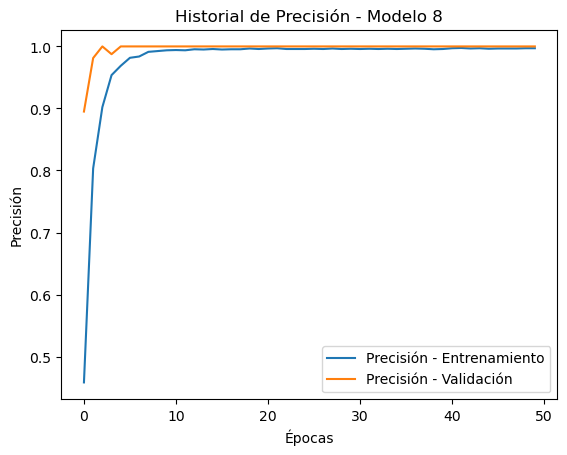

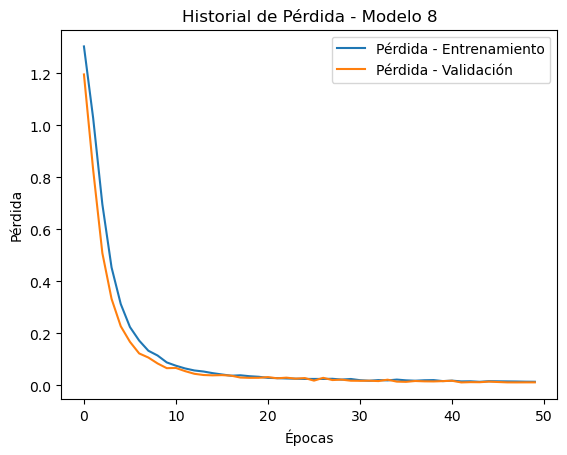


Matriz de Confusión:


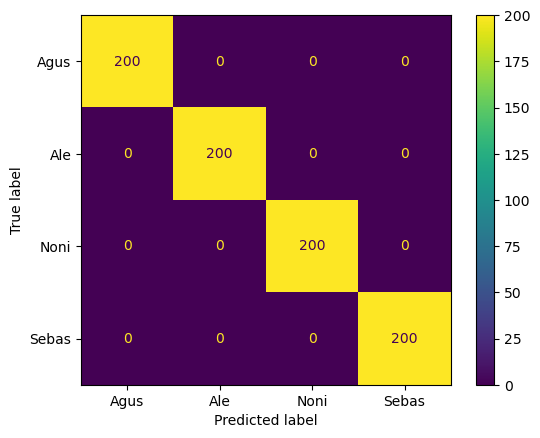



Modelo 9:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 128 neuronas, activación='relu', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 1.0000
Recall: 1.0000

Graficando historial de entrenamiento...


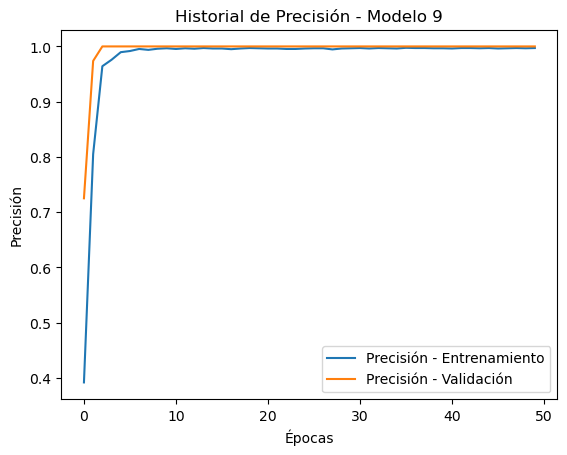

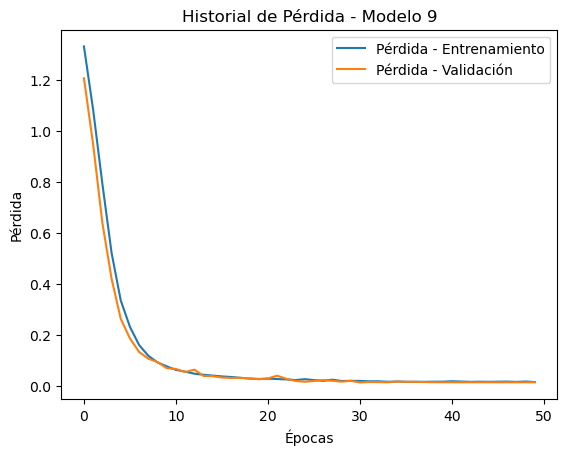


Matriz de Confusión:


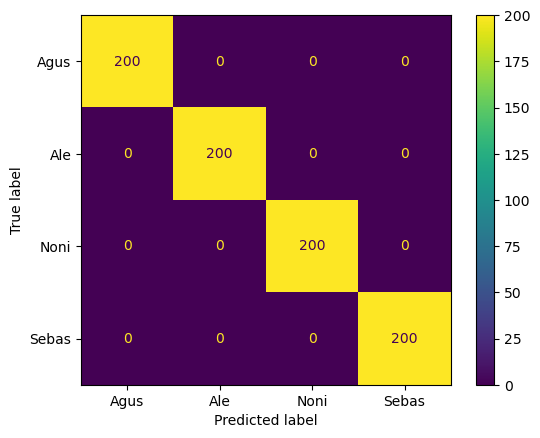



Modelo 10:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 128 neuronas, activación='tanh', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 1.0000
Recall: 1.0000

Graficando historial de entrenamiento...


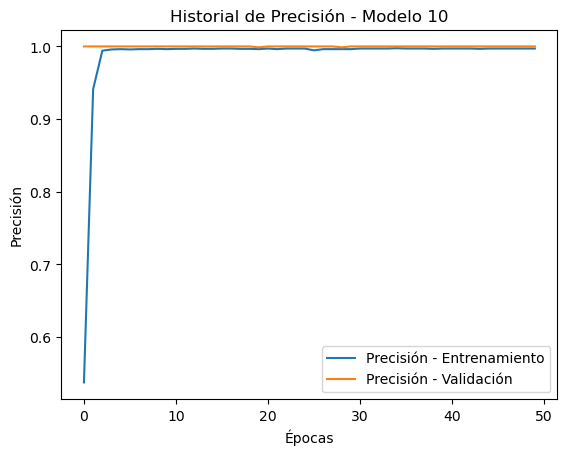

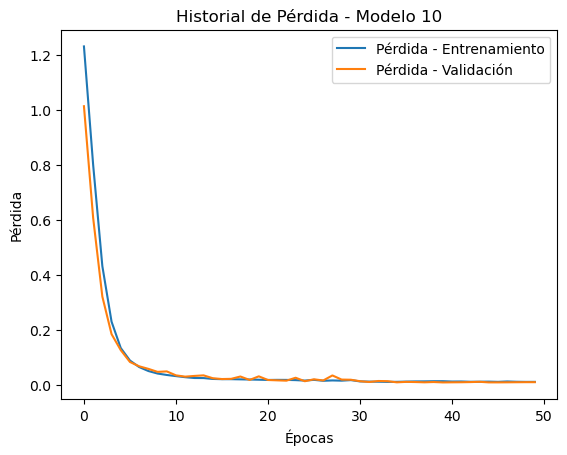


Matriz de Confusión:


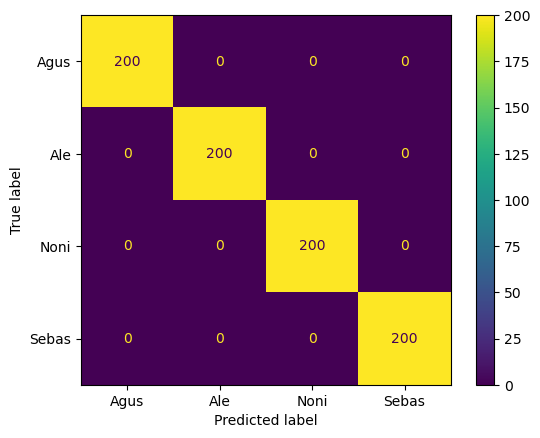



Modelo 11:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 128 neuronas, activación='leaky_relu', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 1.0000
Recall: 1.0000

Graficando historial de entrenamiento...


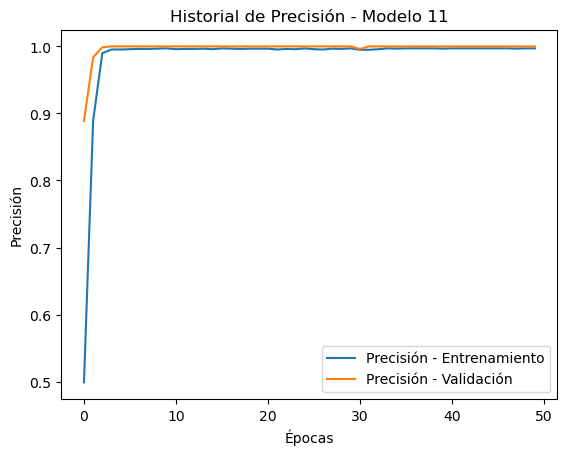

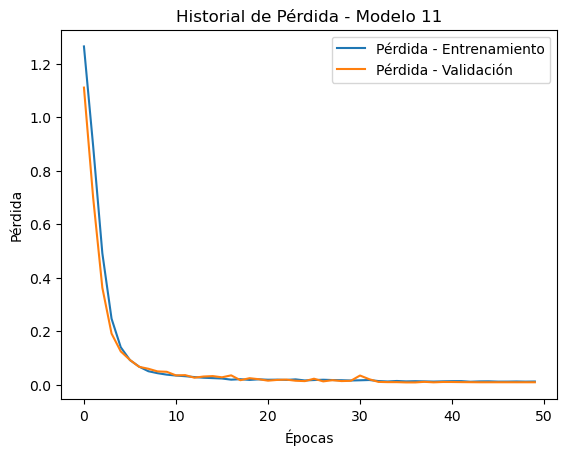


Matriz de Confusión:


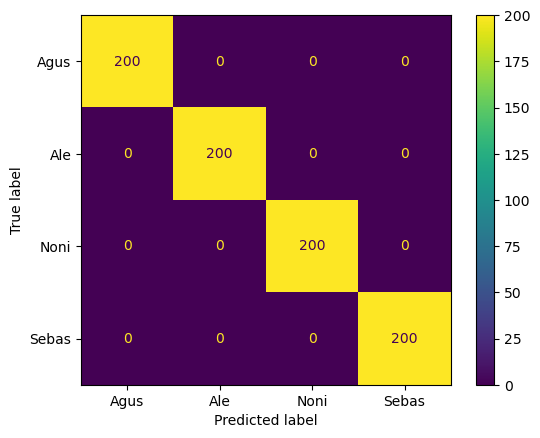



Modelo 12:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 128 neuronas, activación='swish', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 1.0000
Recall: 1.0000

Graficando historial de entrenamiento...


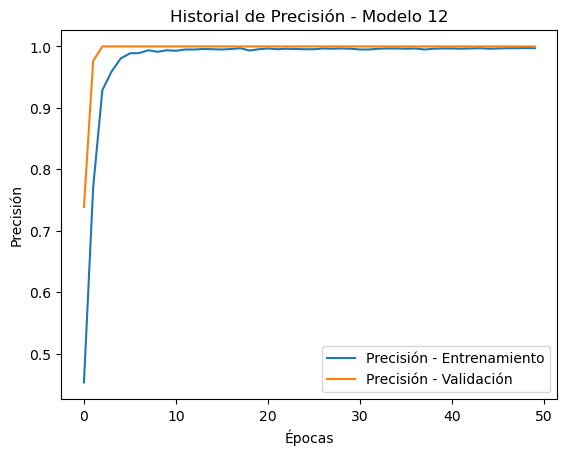

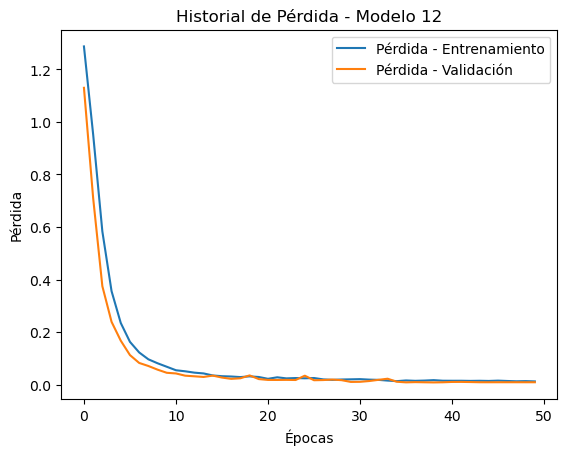


Matriz de Confusión:


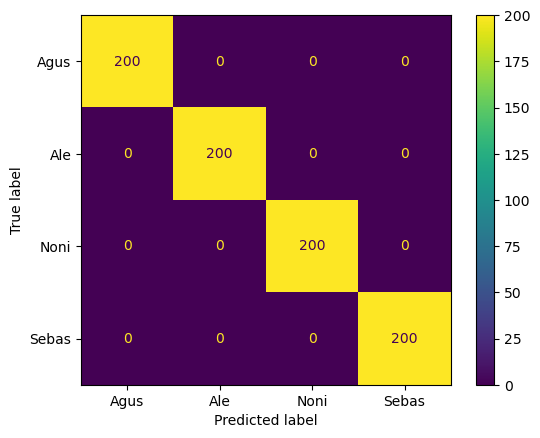



Modelo 13:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 128 neuronas, activación='relu', dropout=0.2
  Capa 2: 64 neuronas, activación='relu', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 1.0000
Recall: 1.0000

Graficando historial de entrenamiento...


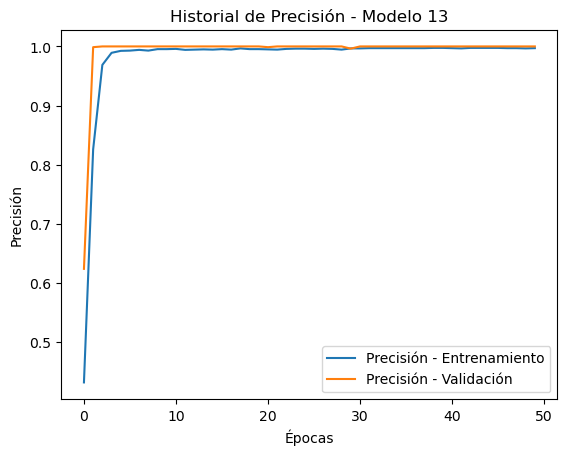

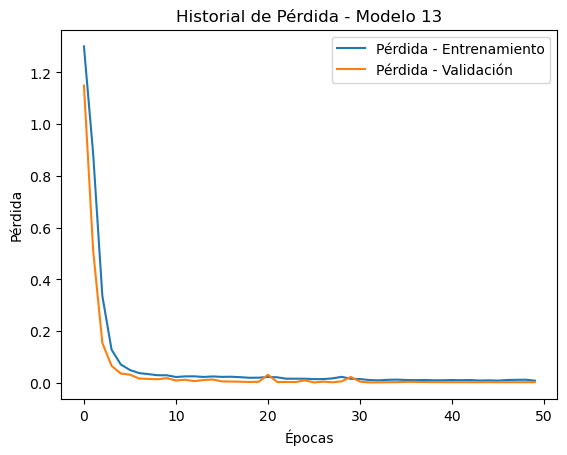


Matriz de Confusión:


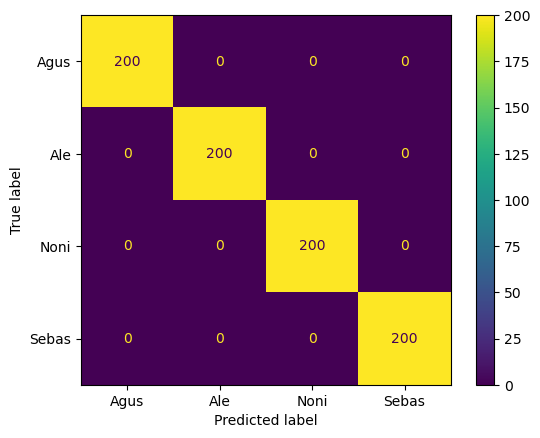



Modelo 14:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 128 neuronas, activación='leaky_relu', dropout=0.2
  Capa 2: 64 neuronas, activación='leaky_relu', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 1.0000
Recall: 1.0000

Graficando historial de entrenamiento...


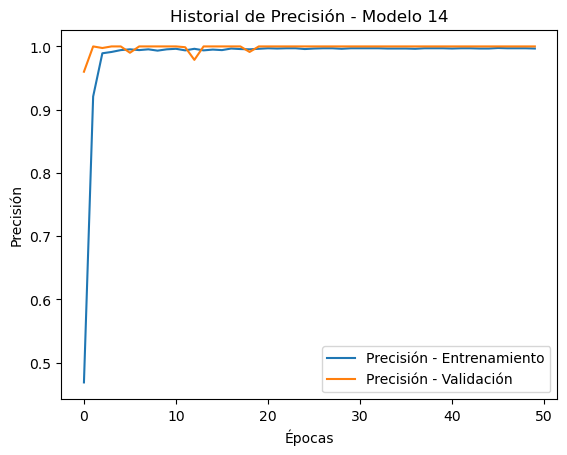

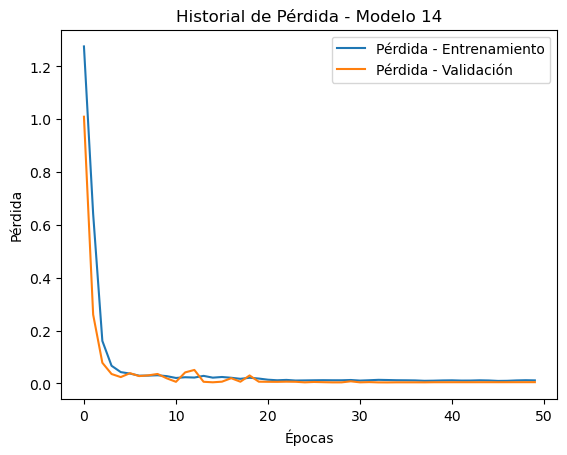


Matriz de Confusión:


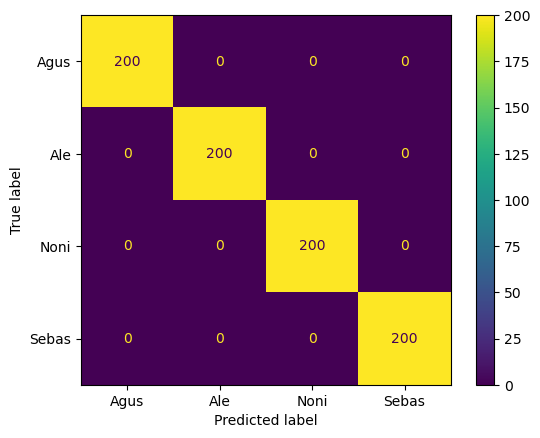



Modelo 15:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 128 neuronas, activación='swish', dropout=0.2
  Capa 2: 64 neuronas, activación='swish', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 1.0000
Recall: 1.0000

Graficando historial de entrenamiento...


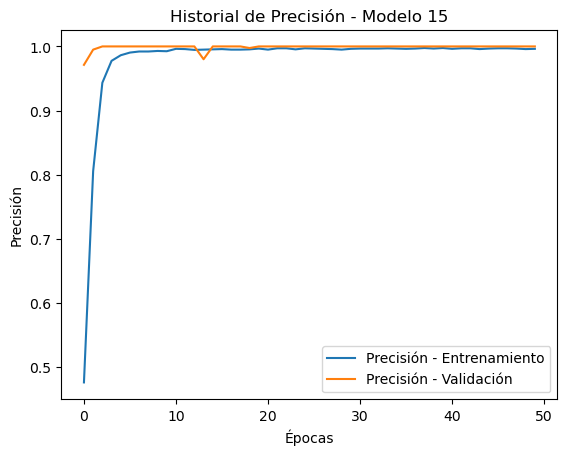

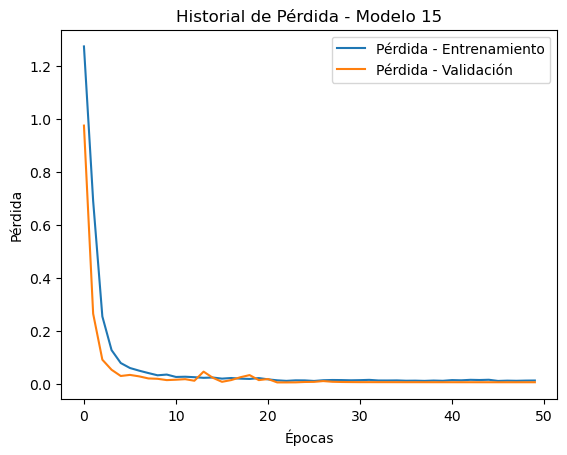


Matriz de Confusión:


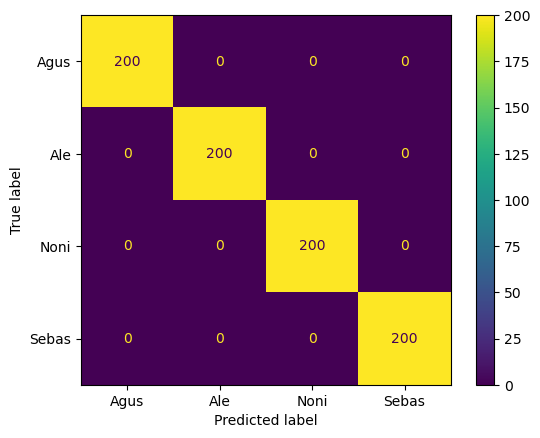



Modelo 16:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 64 neuronas, activación='relu', dropout=0.2
  Capa 2: 32 neuronas, activación='relu', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 1.0000
Recall: 1.0000

Graficando historial de entrenamiento...


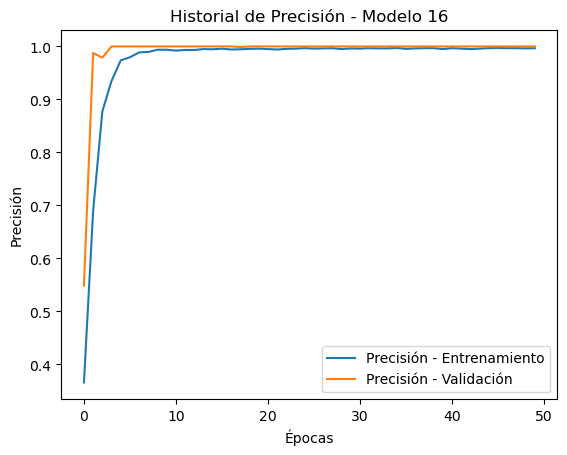

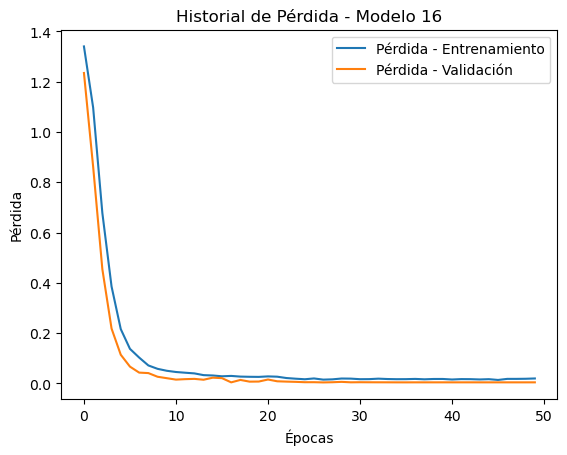


Matriz de Confusión:


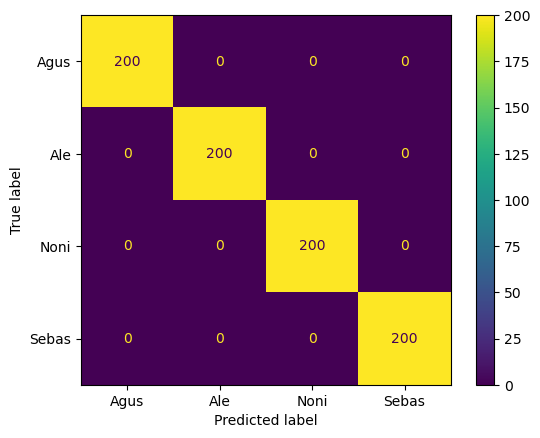



Modelo 17:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 64 neuronas, activación='leaky_relu', dropout=0.2
  Capa 2: 32 neuronas, activación='leaky_relu', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 1.0000
Recall: 1.0000

Graficando historial de entrenamiento...


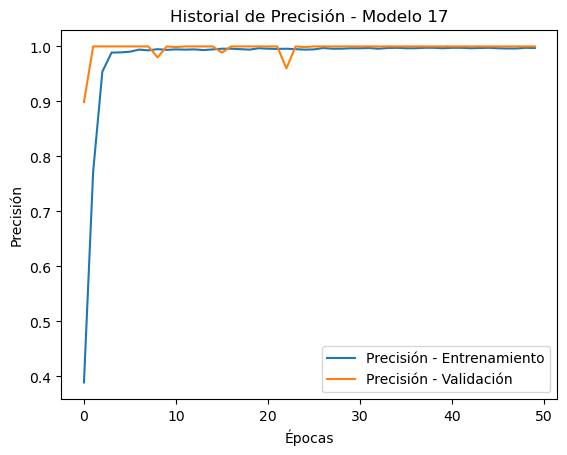

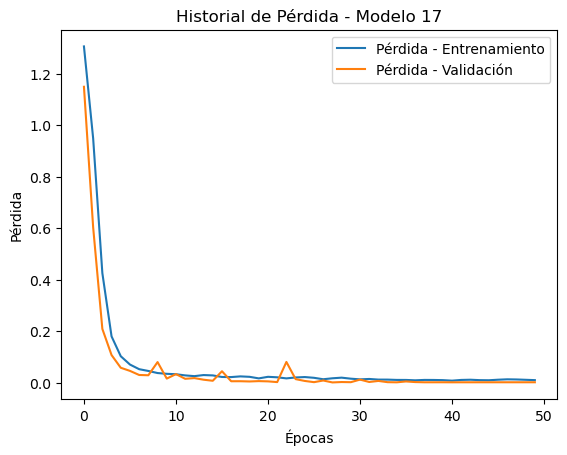


Matriz de Confusión:


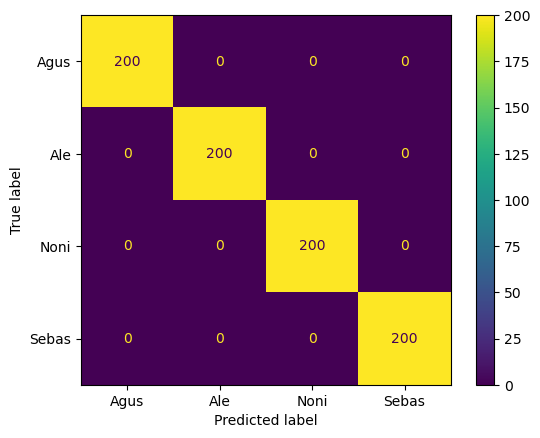



Modelo 18:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 64 neuronas, activación='swish', dropout=0.2
  Capa 2: 32 neuronas, activación='swish', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 1.0000
Recall: 1.0000

Graficando historial de entrenamiento...


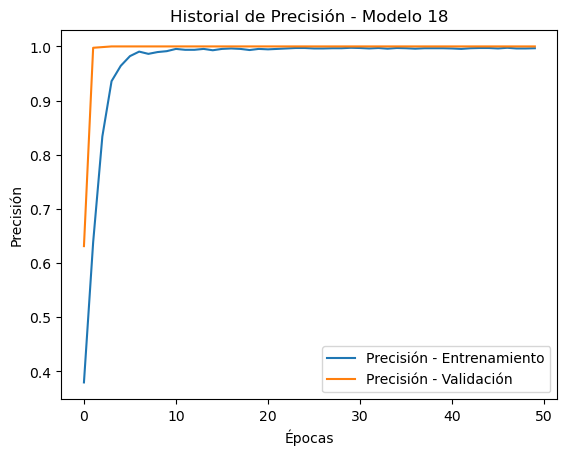

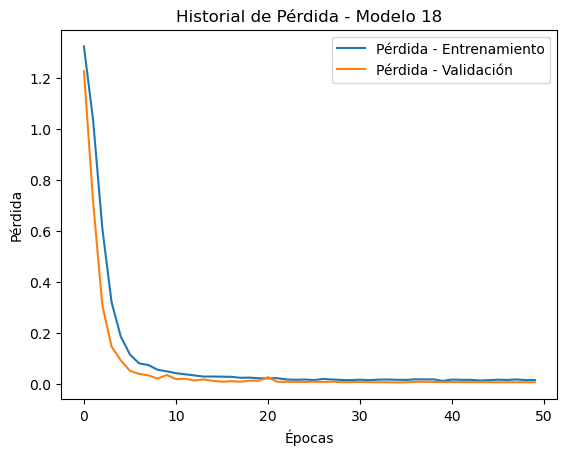


Matriz de Confusión:


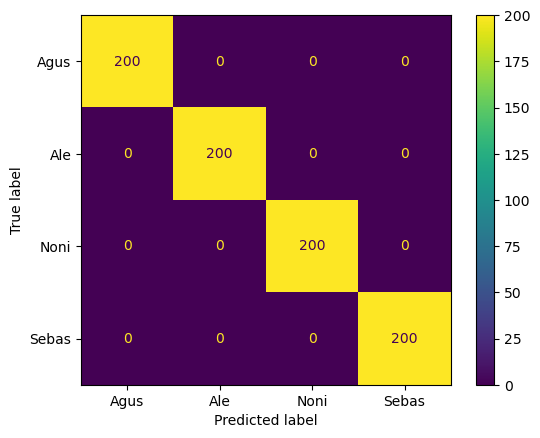



Modelo 19:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 128 neuronas, activación='relu', dropout=0.2
  Capa 2: 64 neuronas, activación='relu', dropout=0.15
  Capa 3: 32 neuronas, activación='relu', dropout=0.1
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 1.0000
Recall: 1.0000

Graficando historial de entrenamiento...


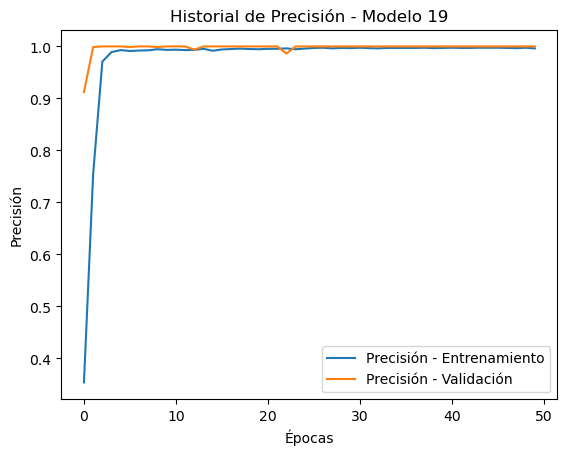

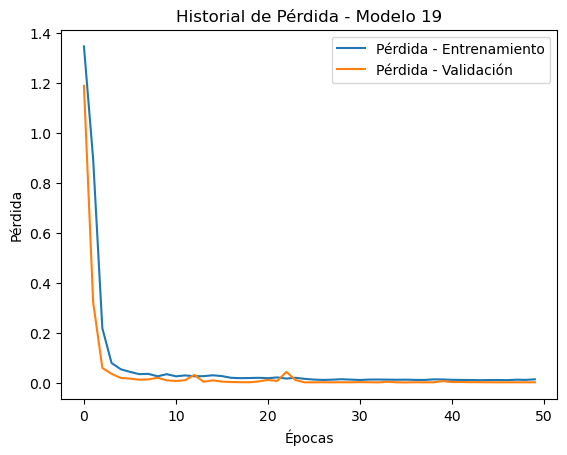


Matriz de Confusión:


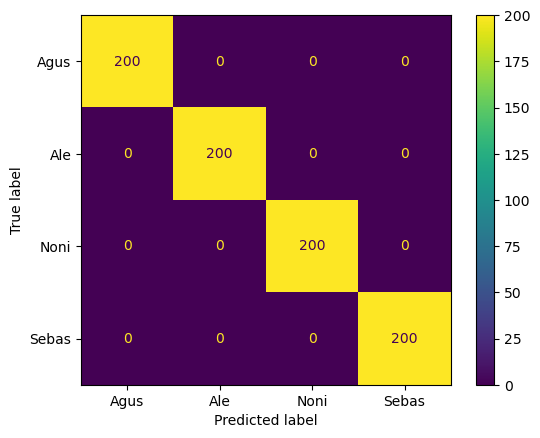



Modelo 20:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 128 neuronas, activación='leaky_relu', dropout=0.2
  Capa 2: 64 neuronas, activación='leaky_relu', dropout=0.15
  Capa 3: 32 neuronas, activación='leaky_relu', dropout=0.1
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 1.0000
Recall: 1.0000

Graficando historial de entrenamiento...


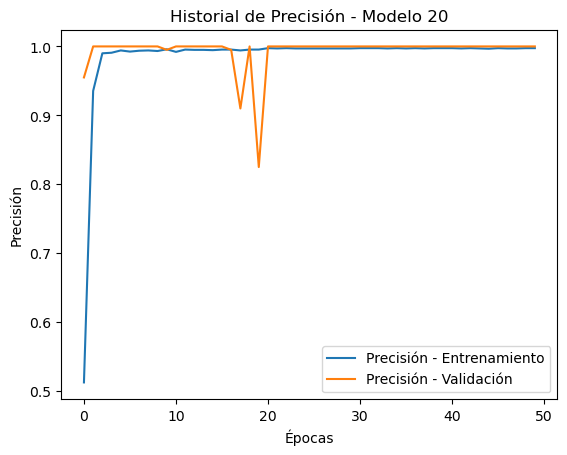

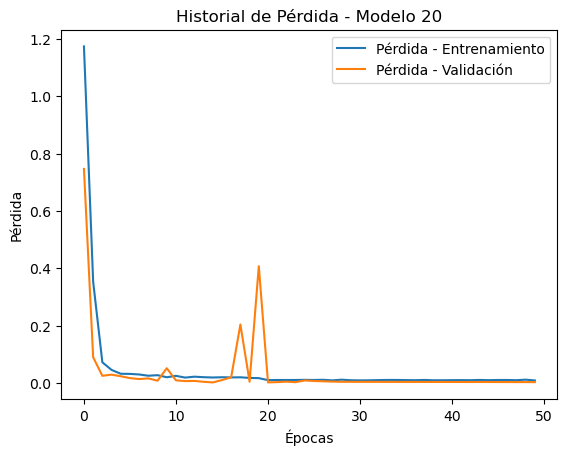


Matriz de Confusión:


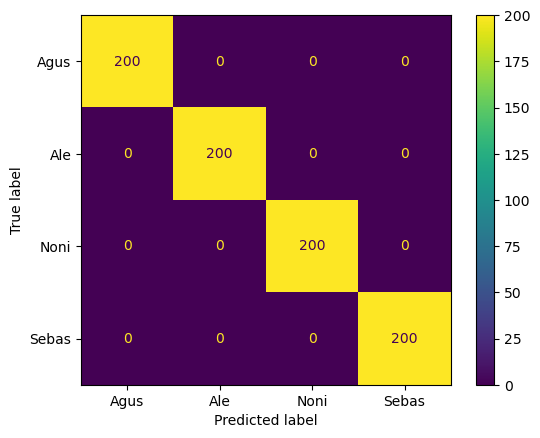



Modelo 21:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 128 neuronas, activación='swish', dropout=0.2
  Capa 2: 64 neuronas, activación='swish', dropout=0.15
  Capa 3: 32 neuronas, activación='swish', dropout=0.1
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 1.0000
Recall: 1.0000

Graficando historial de entrenamiento...


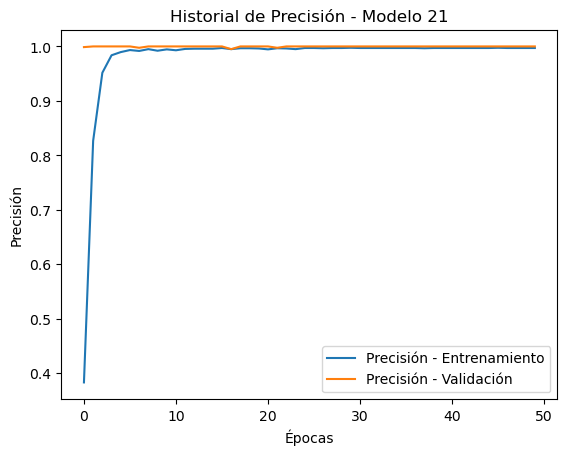

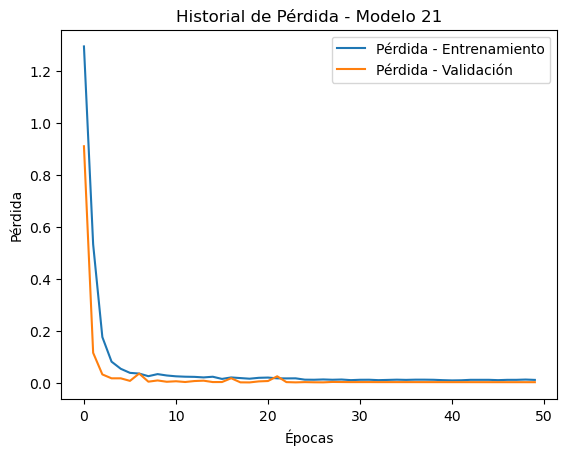


Matriz de Confusión:


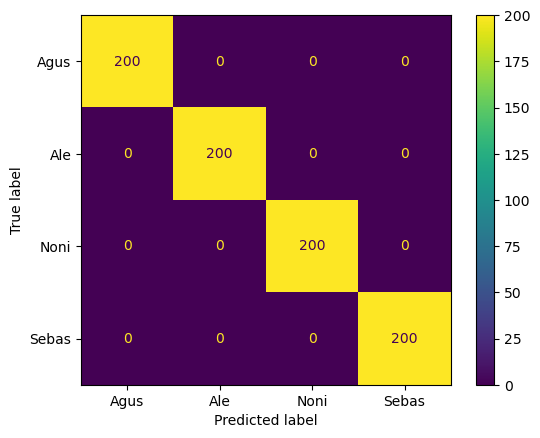



Modelo 22:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 64 neuronas, activación='relu', dropout=0.15
  Capa 2: 32 neuronas, activación='relu', dropout=0.1
  Capa 3: 16 neuronas, activación='relu', dropout=0.05
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 1.0000
Recall: 1.0000

Graficando historial de entrenamiento...


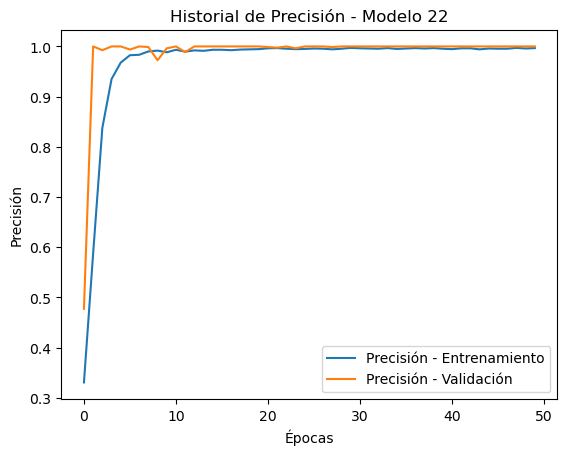

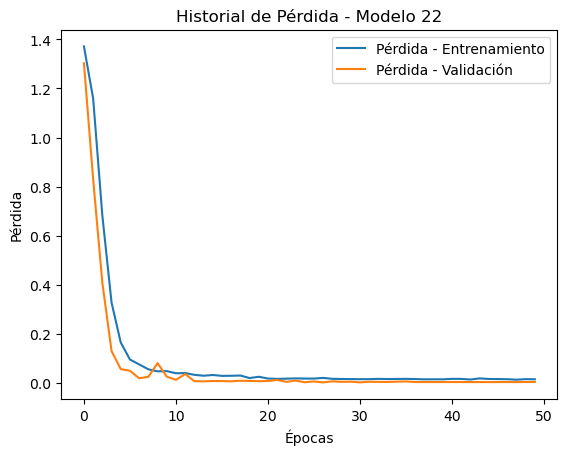


Matriz de Confusión:


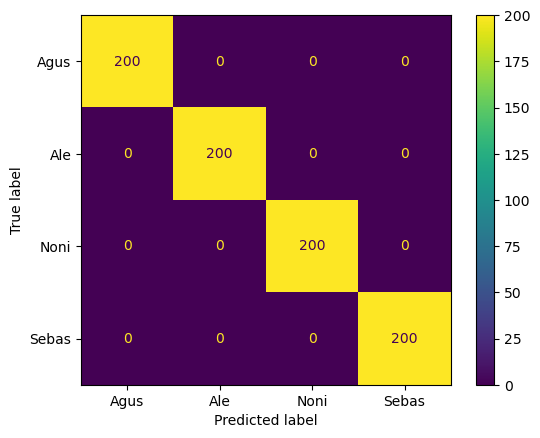



Modelo 23:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 64 neuronas, activación='leaky_relu', dropout=0.15
  Capa 2: 32 neuronas, activación='leaky_relu', dropout=0.1
  Capa 3: 16 neuronas, activación='leaky_relu', dropout=0.05
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 1.0000
Recall: 1.0000

Graficando historial de entrenamiento...


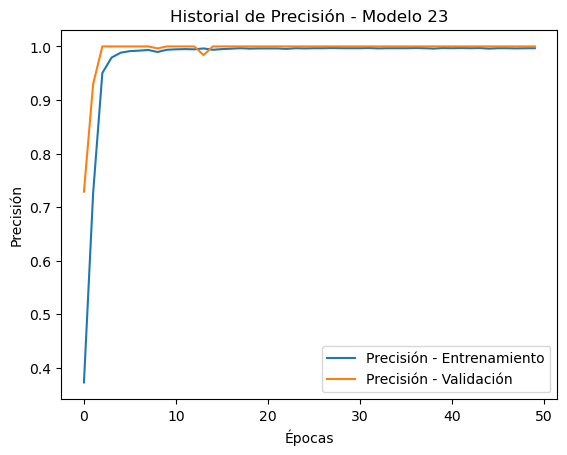

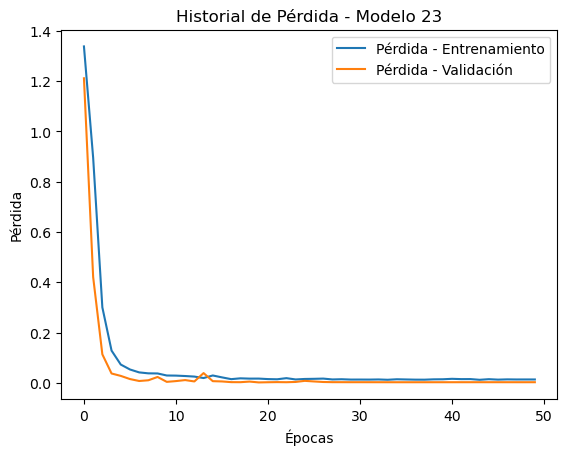


Matriz de Confusión:


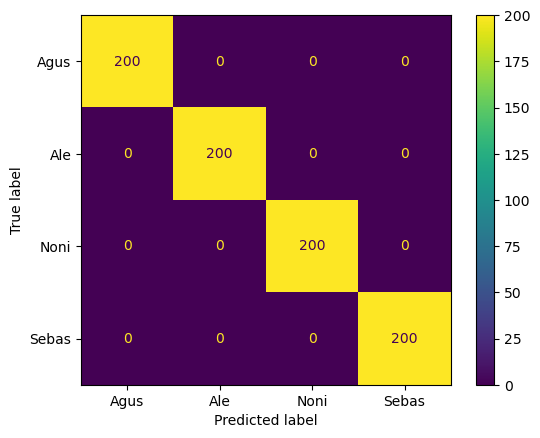



Modelo 24:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 64 neuronas, activación='swish', dropout=0.15
  Capa 2: 32 neuronas, activación='swish', dropout=0.1
  Capa 3: 16 neuronas, activación='swish', dropout=0.05
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 1.0000
Recall: 1.0000

Graficando historial de entrenamiento...


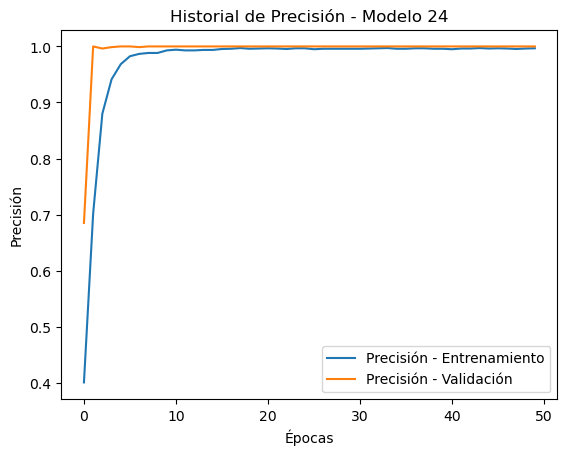

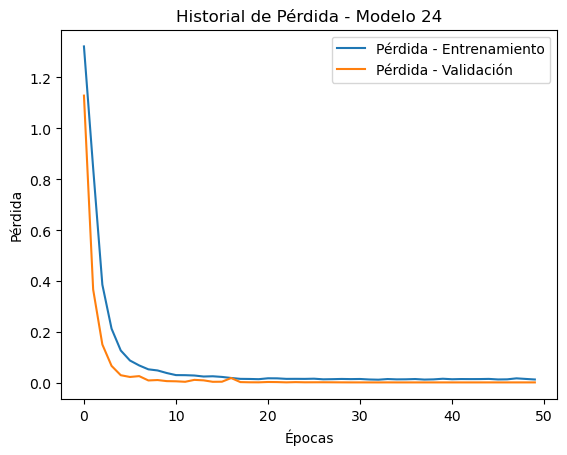


Matriz de Confusión:


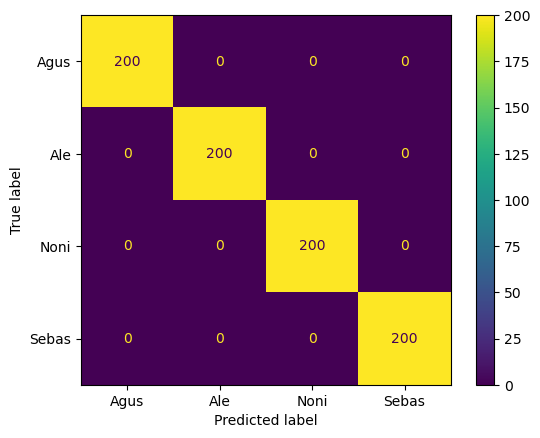

In [42]:
def mostrar_configuracion(configuracion):
    salida = []
    salida.append("Capas Ocultas:")
    for i, capa in enumerate(configuracion["capas_ocultas"]):
        salida.append(f"  Capa {i + 1}: {capa['neuronas']} neuronas, activación='{capa['activation']}', dropout={capa.get('dropout', 0)}")
    salida.append(f"Learning Rate: {configuracion['learning_rate']}")
    salida.append(f"Factor de Reducción: {configuracion['factor_reduccion']}")
    salida.append(f"Salida: {configuracion['output']['neuronas']} neuronas, activación='{configuracion['output']['activation']}'")
    return "\n".join(salida)

def mostrar_todo_dataframe(df, labels):
    for index, fila in df.iterrows():
        print(f"Modelo {index + 1}:")
        print("-" * 40)
        
        print("Configuración del modelo:")
        print(mostrar_configuracion(fila["configuracion"]))
        
        print("\nMétricas del modelo:")
        print(f"Precisión: {fila['precision']:.4f}")
        print(f"Recall: {fila['recall']:.4f}")
        
        historial = fila["historial"]
        print("\nGraficando historial de entrenamiento...")
        plt.plot(historial["accuracy"], label="Precisión - Entrenamiento")
        plt.plot(historial["val_accuracy"], label="Precisión - Validación")
        plt.title(f"Historial de Precisión - Modelo {index + 1}")
        plt.xlabel("Épocas")
        plt.ylabel("Precisión")
        plt.legend()
        plt.show()

        plt.plot(historial["loss"], label="Pérdida - Entrenamiento")
        plt.plot(historial["val_loss"], label="Pérdida - Validación")
        plt.title(f"Historial de Pérdida - Modelo {index + 1}")
        plt.xlabel("Épocas")
        plt.ylabel("Pérdida")
        plt.legend()
        plt.show()

        print("\nMatriz de Confusión:")
        cm_display = ConfusionMatrixDisplay(fila["matriz_confusion"], display_labels=labels)
        cm_display.plot()
        plt.show()

        print("\n" + "=" * 50 + "\n")

mostrar_todo_dataframe(df_resultados, labels=labels)
